In [1]:
# Python imports
from functools import partial
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sympy.physics.quantum.cg import CG

In [2]:
# JAX imports
from jax import config, jit, vmap
import jax.numpy as jnp
from jax.numpy.linalg import eigh, solve, det
from jax.scipy.special import sph_harm, factorial
from jaxinterp2d import interp2d

In [3]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_channel
from scripts.integration import gaussian_quadrature_mesh
from scripts.tools import channel_L_value, coupled_channel, replace_periods

In [4]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [5]:
class Potential:
    """Class that loads NN potentials as JAX arrays."""
    
    # Define class attribute for h-bar^2 / M [MeV fm^2]
    hbar_sq_over_m = 41.47
    
    def __init__(self, kvnn, kmax, kmid, ntot, L_max=2):
        
        # Need kvnn as string (can cause error if kvnn < 10)
        if kvnn < 10:
            kvnn_str = '0' + str(kvnn)
        else:
            kvnn_str = str(kvnn)
        self.kvnn_str = kvnn_str
        
        # Get potential directory
        kmax_int = int(kmax)
        kmid_int = int(kmid)
        self.directory = (
            f'../data/potentials/vsrg_kvnn_{kvnn_str}_lam12.0_kmax{kmax_int:d}'
            f'_kmid{kmid_int:d}_ntot{ntot:d}/'
        )

        # Set momentum mesh in units fm^-1
        self.k_array, self.k_weights = self.get_momentum_mesh()
        
        # Set momentum mesh specifications as attributes
        self.kmax, self.kmid, self.ntot = kmax, kmid, ntot
        
        # Set potentials up to L_max in a big JAX arrays distinguishing
        # uncoupled- or coupled-channel
        self.uncoupled_potentials, self.coupled_potentials = (
            self.get_potentials(L_max)
        )
        
    def get_momentum_mesh(self):
        """Momentum mesh in units [fm^-1] as JAX arrays."""
        
        filename = f'vsrg_1S0_kvnn_{self.kvnn_str}_lam12.0_reg_0_3_0_mesh.out'
        momentum_mesh = np.loadtxt(self.directory + filename)
        k_array = jnp.asarray(momentum_mesh[:, 0])
        k_weights = jnp.asarray(momentum_mesh[:, 1])
        
        return k_array, k_weights
    
    def get_potentials(self, L_max):
        """JAX arrays of potentials up to L_max returning uncoupled- and
        coupled-channel potentials separately."""
        
        # Initialize potentials as lists later to be converted to JAX arrays
        uncoupled_potentials_list = []
        coupled_potentials_list = []
        
        # Possible partial wave channels up to L = 5
        channels = [
            '1S0', '3S1', '3P0', '1P1', '3P1', '3P2', '1D2', '3D2', '3D3',
            '1F3', '3F3', '3F4', '1G4', '3G4', '3G5', '1H5', '3H5', '3H6'
        ]
        
        # Loop over channels
        for channel in channels:

            # Check that channel is within L_max
            L = channel_L_value(channel)
            if L <= L_max:
                
                # Load potential [fm]
                V_matrix = self.load_potential(channel)

                # Coupled-channel
                if coupled_channel(channel):
                    coupled_potentials_list.append(V_matrix)
                # Uncoupled-channel
                else:
                    uncoupled_potentials_list.append(V_matrix)
                    
        # Convert lists to JAX arrays with shape (# of channels, ntot, ntot)
        uncoupled_potentials = jnp.asarray(uncoupled_potentials_list)
        coupled_potentials = jnp.asarray(coupled_potentials_list)

        return uncoupled_potentials, coupled_potentials
            
    def load_potential(self, channel):
        """Load the potential in the given partial wave channel."""
        
        filename = f'vnn_{channel}_kvnn_{self.kvnn_str}_lam12.0_reg_0_3_0.out'
        data = np.loadtxt(self.directory + filename)
        
        # Coupled-channel potential?
        if coupled_channel(channel):
        
            V11 = jnp.reshape(data[:, 2], (self.ntot, self.ntot))
            V12 = jnp.reshape(data[:, 3], (self.ntot, self.ntot))
            V21 = jnp.reshape(data[:, 4], (self.ntot, self.ntot))
            V22 = jnp.reshape(data[:, 5], (self.ntot, self.ntot))
            V_matrix = jnp.vstack(
                (jnp.hstack((V11, V12)), jnp.hstack((V21, V22)))
            )
        
        else:
        
            V_matrix = jnp.reshape(data[:, 2], (self.ntot, self.ntot))

        # Potential in units [fm] where the shape can vary
        return V_matrix
    
    def load_kinetic_energy(self, channel):
        """Loads relative kinetic energy."""

        # Matrix of (h-bar*k)^2 / M along diagonal [MeV]
        T_matrix = jnp.diag(self.k_array ** 2) * self.hbar_sq_over_m
    
        # Coupled-channel operator?
        if coupled_channel(channel):
        
            # Matrix of zeros (n x n)
            zeros = jnp.zeros((self.ntot, self.ntot))
        
            # Build coupled-channel kinetic energy matrix
            T_matrix = jnp.vstack(
                (jnp.hstack((T_matrix, zeros)), jnp.hstack((zeros, T_matrix)))
            )
        
        # Kinetic energy in units [MeV]
        return T_matrix
    
    def load_hamiltonian(self, channel):
        """Loads the Hamiltonian."""
        
        # Load relative kinetic energy [MeV]
        T_matrix = self.load_kinetic_energy(channel)
    
        # Load potential [fm]
        V_matrix_fm = self.load_potential(channel)

        # Convert potential from [fm] -> [MeV]
        V_matrix_MeV = self.hbar_sq_over_m * self.attach_integration_weights(
            V_matrix_fm, channel
        )
    
        H_matrix = T_matrix + V_matrix_MeV
    
        # Hamiltonian in units MeV
        return H_matrix
    
    def attach_integration_weights(self, V_matrix_fm, channel):
        """Attach integration k_i^2 w_i factor to potential."""
        
        # Get integration factor as a 1-D array
        factor_array = self.integration_measure(channel)
        
        # 1-D array to 2-D grid
        factor_i_grid, factor_j_grid = jnp.meshgrid(factor_array, factor_array,
                                                    indexing='ij')
    
        # Multiply the potential by the integration measure [fm^-2]
        return factor_i_grid * factor_j_grid * V_matrix_fm
    
    def integration_measure(self, channel):
        """Get factor k_i^2 w_i."""
        
        # Make array of integration factor [fm^-3/2]
        if coupled_channel(channel):
            factor_array = jnp.concatenate((
                jnp.sqrt(2 / jnp.pi * self.k_weights) * self.k_array,
                jnp.sqrt(2 / jnp.pi * self.k_weights) * self.k_array
            ))
        else:
            factor_array = jnp.sqrt(2 / jnp.pi * self.k_weights) * self.k_array
        
        # Return 1-D array with units [fm^-3/2]
        return factor_array

    @partial(jit, static_argnums=(0,))
    def get_uncoupled_potential(self, L, S, J):
        
        # Map L, S, and J onto index (special case for 3P0)
        cond = jnp.logical_and(L == 1, jnp.logical_and(S == 1, J == 0))
        index = jnp.where(cond, 1, L + S + J)
        
        # Units are [fm] and shape is (ntot, ntot)
        return self.uncoupled_potentials[index]
    
    @partial(jit, static_argnums=(0,))
    def get_coupled_potential(self, J):
        
        # Map J onto index
        index = J - 1
        
        # Units are [fm] and shape is (2*ntot, 2*ntot)
        return self.coupled_potentials[index]
    
    @partial(jit, static_argnums=(0,))
    def is_coupled(self, L, J):
        """Boolean value on whether the channel is coupled or not."""
        
        return jnp.logical_and(J > 0, J != L)

In [6]:
class TMatrix(Potential):
    """Class that computes the NN T-matrix."""
    
    def __init__(self, kvnn, kmax, kmid, ntot, L_max=2):
        
        # Initializes potentials up to L_max
        super().__init__(kvnn, kmax, kmid, ntot, L_max)

        # Maximum momentum [fm^-1]
        self.lamb = kmax
        
    @partial(jit, static_argnums=(0,))
    def half_offshell(self, pp, L, Lp, S, J):
        """Compute the half off-shell T-matrix T_{L, L'}(k_i, p'; E'=p'^2/M)
        for a particular partial wave channel.
        """
        
        # T-matrix in units [fm] with shape (ntot+1, ntot+1)
        T_matrix = self.compute(pp, L, Lp, S, J)
        
        # Half off-shell T-matrix in units [fm] with shape (ntot, 1)
        return T_matrix[:self.ntot, self.ntot]
    
    @partial(jit, static_argnums=(0,))
    def onshell(self, pp, L, Lp, S, J):
        """Compute the on-shell T-matrix T_{L, L'}(p', p'; E'=p'^2/M) for a
        particular partial wave channel.
        """
        
        # T-matrix in units [fm] with shape (ntot+1, ntot+1)
        T_matrix = self.compute(pp, L, Lp, S, J)
        
        # Half off-shell T-matrix in units [fm] which is a complex scalar
        return T_matrix[self.ntot, self.ntot]
    
    @partial(jit, static_argnums=(0,))
    def compute(self, pp, L, Lp, S, J):
        """Compute the T-matrix for given momentum p' with energy E' = p'^2 / M
        for a particular partial wave channel.
        """
        
        # Condition on whether the channel is coupled or not
        cond = self.is_coupled(L, J)
        T_matrix = jnp.where(
            cond, self.compute_coupled(pp, L, Lp, J),
            self.compute_uncoupled(pp, L, S, J)
        )
        
        # T-matrix in units [fm] with shape (ntot+1, ntot+1)
        return T_matrix
    
    @partial(jit, static_argnums=(0,))
    def compute_uncoupled(self, pp, L, S, J):
        """Compute the half off-shell T-matrix in a uncoupled-channel."""

        # Evaluate D-vector for solving matrix inversion problem
        D_vector = self.D_vector(pp)
        
        # Append p' to end of mesh (ntot+1,)
        k_full = jnp.append(self.k_array, pp)
        
        # Create meshes for interpolation (ntot+1, ntot+1)
        k_grid, kp_grid = jnp.meshgrid(k_full, k_full, indexing='ij')
        
        # Load potential in units [fm] with shape (ntot, ntot)
        V_matrix = self.get_uncoupled_potential(L, S, J)

        # Append p' points by linear interpolation (ntot+1, ntot+1)
        V_interpolated = interp2d(k_grid, kp_grid, self.k_array, self.k_array,
                                  V_matrix)
        
        # Build F-matrix [unitless] where F_ij = \delta_ij + D_j V_ij
        F_matrix = (jnp.identity(self.ntot + 1)
                    + jnp.tile(D_vector, (self.ntot + 1, 1)) * V_interpolated)
        
        ### TESTING FLIPPED SIGN ON D_j and F_ij
#         F_matrix = (jnp.identity(self.ntot + 1)
#                     - jnp.tile(D_vector, (self.ntot + 1, 1)) * V_interpolated)

        # Solve for T-matrix by matrix inversion
        T_matrix = solve(F_matrix, V_interpolated)

        # Units are [fm] and shape is (ntot+1, ntot+1)
        return T_matrix
    
    @partial(jit, static_argnums=(0,))
    def compute_coupled(self, pp, L, Lp, J):
        """Compute the half off-shell T-matrix in a coupled-channel."""
        
        # Evaluate D-vector for solving matrix inversion problem
        D_vector = self.D_vector(pp)
        
        # Append p' to end of mesh (ntot+1,)
        k_full = jnp.append(self.k_array, pp)
        
        # Create meshes for interpolation (ntot+1, ntot+1)
        k_grid, kp_grid = jnp.meshgrid(k_full, k_full, indexing='ij')
        
        # Load potential in units [fm] with shape (2*ntot, 2*ntot)
        V_matrix = self.get_coupled_potential(J)

        # Append p' points by linear interpolation (2*ntot+2, 2*ntot+2)
        V_interpolated = self.interpolate_coupled_potential(k_grid, kp_grid,
                                                            V_matrix)
        
        # Build F-matrix [unitless] where F_ij = \delta_ij + D_j V_ij
        F_matrix = (
            jnp.identity(2 * (self.ntot + 1))
            + jnp.tile(D_vector, (2 * (self.ntot + 1), 2)) * V_interpolated
        )

        # Solve for T-matrix by matrix inversion
        T_matrix = solve(F_matrix, V_interpolated)
        
        # Select particular sub-block of coupled-channel matrix
        T_subblock = self.select_subblock(L, Lp, J, T_matrix)

        # Units are [fm] and shape is (ntot+1, ntot+1)
        return T_subblock
    
    @partial(jit, static_argnums=(0,))
    def D_vector(self, pp):
        """Compute D-vector used for solving matrix inversion problem:
            T = F^-1 V
        where F_ij = \delta_ij + D_j V_ij.
        """
        
        # First ntot elements of D_vector [fm^-1]
        D_vector = (2.0 / jnp.pi * (self.k_weights * self.k_array ** 2)
                    / (self.k_array ** 2 - pp ** 2))
        
        ### TESTING FLIPPED SIGN ON D_j and F_ij
#         D_vector = (2.0 / jnp.pi * (self.k_weights * self.k_array ** 2)
#                     / (pp ** 2 - self.k_array ** 2))
        
        # ntot + 1 element of D_vector [fm^-1]
#         D_last = (
#             -2.0 / jnp.pi * pp ** 2 * (
#                 jnp.sum(self.k_weights / (self.k_array ** 2 - pp ** 2))
#                 + jnp.log((self.lamb + pp) / (self.lamb - pp)) / (2.0 * pp)
#             )
#         ) - 1j * pp

        ### TESTING FLIPPED SIGN ON D_j and F_ij
#         D_last = (
#             -2.0 / jnp.pi * pp ** 2 * (
#                 jnp.sum(self.k_weights / (pp ** 2 - self.k_array ** 2))
#                 + jnp.log((self.lamb - pp) / (self.lamb + pp)) / (2.0 * pp)
#             )
#         ) + 1j * pp

        ### TESTING OPPOSITE SIGN ON IMAGINARY PART
        D_last = (
            -2.0 / jnp.pi * pp ** 2 * (
                jnp.sum(self.k_weights / (self.k_array ** 2 - pp ** 2))
                + jnp.log((self.lamb + pp) / (self.lamb - pp)) / (2.0 * pp)
            )
        ) + 1j * pp
        
        # Append ntot + 1 element to D_vector
        return jnp.append(D_vector, D_last)

    @partial(jit, static_argnums=(0,))
    def interpolate_coupled_potential(self, k_grid, kp_grid, V_matrix):
        """Interpolate half off-shell T-matrix matrix in a coupled-channel."""
        
        # Get each sub-block separately with shapes (ntot, ntot)
        V11, V12, V21, V22 = self.get_subblocks(V_matrix)
        
        # Append p' points by linear interpolation (ntot+1, ntot+1)
        V11_interpolated = interp2d(k_grid, kp_grid, self.k_array, self.k_array,
                                    V11)
        V12_interpolated = interp2d(k_grid, kp_grid, self.k_array, self.k_array,
                                    V12)
        V21_interpolated = interp2d(k_grid, kp_grid, self.k_array, self.k_array,
                                    V21)
        V22_interpolated = interp2d(k_grid, kp_grid, self.k_array, self.k_array,
                                    V22)
        
        # Recombine sub-blocks for coupled-channel matrix
        V_interpolated = jnp.vstack((
            jnp.hstack((V11_interpolated, V12_interpolated)),
            jnp.hstack((V21_interpolated, V22_interpolated))
        ))

        # Shape is (2*ntot+2, 2*ntot+2)
        return V_interpolated
    
    @partial(jit, static_argnums=(0,))
    def select_subblock(self, L, Lp, J, T_matrix):
        """Select a particular sub-block (L and L') of a coupled-channel T-
        matrix.
        """
        
        # List of conditions for each sub-block
        condlist = [
            jnp.logical_and(L == Lp, J > L),   # 0-0 sub-block
            jnp.logical_and(L != Lp, J > L),   # 0-2 sub-block
            jnp.logical_and(L != Lp, J > Lp),  # 2-0 sub-block
            jnp.logical_and(L == Lp, J < L)    # 2-2 sub-block
        ]
        
        # List of the T-matrix in each sub-block
        choicelist = [
            T_matrix[:self.ntot+1, :self.ntot+1],
            T_matrix[:self.ntot+1, self.ntot+1:],
            T_matrix[self.ntot+1:, :self.ntot+1],
            T_matrix[self.ntot+1:, self.ntot+1:]
        ]
        
        # Get particular sub-block with shape (ntot+1, ntot+1)
        T_subblock = jnp.select(condlist, choicelist)
        
        # Units remain [fm]
        return T_subblock
    
    @partial(jit, static_argnums=(0,))
    def get_subblocks(self, V_matrix):
        """Gets each sub-block (L and L') from a coupled-channel potential."""
        
        V11 = V_matrix[:self.ntot, :self.ntot]
        V12 = V_matrix[:self.ntot, self.ntot:]
        V21 = V_matrix[self.ntot:, :self.ntot]
        V22 = V_matrix[self.ntot:, self.ntot:]

        return V11, V12, V21, V22
    
    @partial(jit, static_argnums=(0,))
    def test_phase_shifts(self, k0, L, Lp, S, J):
        """Get phase shift from the T-matrix with scattering energy
            E = (\hbar*k0)^2 / M.
        Note, this won't work for coupled-channels yet.
        """
        
        T_matrix = self.compute(k0, L, Lp, S, J)
        T_onshell = T_matrix[self.ntot, self.ntot]

        # Phase shift \delta in degrees
        delta = jnp.angle(-k0 * T_onshell, deg=True)
        
        return delta
    
    @partial(jit, static_argnums=(0,))
    def vmap_test_phase_shifts(self, k0_array, L, Lp, S, J):
        """vmap of phase shifts function w.r.t. k0."""
        
        return vmap(
            self.test_phase_shifts, in_axes=(0, None, None, None, None)
        )(k0_array, L, Lp, S, J)
    
    @partial(jit, static_argnums=(0,))
    def test_coupled_phase_shifts(self, k0, J):
        
        # Evaluate D-vector for solving matrix inversion problem
        D_vector = self.D_vector(k0)
        
        # Append p' to end of mesh (ntot+1,)
        k_full = jnp.append(self.k_array, k0)
        
        # Create meshes for interpolation (ntot+1, ntot+1)
        k_grid, kp_grid = jnp.meshgrid(k_full, k_full, indexing='ij')
        
        # Load potential in units [fm] with shape (2*ntot, 2*ntot)
        V_matrix = self.get_coupled_potential(J)

        # Append p' points by linear interpolation (2*ntot+2, 2*ntot+2)
        V_interpolated = self.interpolate_coupled_potential(k_grid, kp_grid,
                                                            V_matrix)
        
        # Build F-matrix [unitless] where F_ij = \delta_ij + D_j V_ij
        F_matrix = (
            jnp.identity(2 * (self.ntot + 1))
            + jnp.tile(D_vector, (2 * (self.ntot + 1), 2)) * V_interpolated
        )

        # Solve for T-matrix by matrix inversion
        T_matrix = solve(F_matrix, V_interpolated)
        T_00 = T_matrix[self.ntot, self.ntot]
        T_02 = T_matrix[self.ntot, 2 * self.ntot + 1]
        T_20 = T_matrix[2 * self.ntot + 1, self.ntot]
        T_22 = T_matrix[2 * self.ntot + 1, 2 * self.ntot + 1]
        
        # S-matrix [unitless] with shape (2,2)
        S_matrix = jnp.array([
            [1 - 2j * k0 * T_00, -2j * k0 * T_02],
            [-2j * k0 * T_20, 1 - 2j * k0 * T_22]
        ])
        
        # Stapp convention phase shifts
        delta_a_bar = 0.5 * jnp.angle(S_matrix[0,0], deg=True)
        delta_b_bar = 0.5 * jnp.angle(S_matrix[1,1], deg=True)
        eps_bar_radians = 0.5 * jnp.arcsin(
            jnp.imag(S_matrix[0,1]) / jnp.real(jnp.sqrt(det(S_matrix)))
        )
        
        return delta_a_bar, delta_b_bar, jnp.degrees(eps_bar_radians)
    
    @partial(jit, static_argnums=(0,))
    def vmap_test_coupled_phase_shifts(self, k0_array, J):
        """vmap of phase shifts function w.r.t. k0."""
        
        return vmap(
            self.test_coupled_phase_shifts, in_axes=(0, None))(k0_array, J)

In [7]:
def convert_channel_to_str(L, S, J):
    
    if L == 0:
        L_str = 'S'
    elif L == 1:
        L_str = 'P'
    elif L == 2:
        L_str = 'D'
    
    S_str = f"{2*S+1:d}"
    J_str = f"{J:d}"
    
    return S_str + L_str + J_str

In [8]:
def compute_uncoupled_phase_shifts(
        e_array, L, Lp, S, J, kvnn, kmax=30.0, kmid=4.0, ntot=120
):
    """Check phase shifts of T-matrix."""
    
    # Convert energy E_lab [MeV] to relative momentum [fm^-1]
    k0_array = jnp.sqrt(e_array / 2 / Potential.hbar_sq_over_m)
    
    tmatrix = TMatrix(kvnn, kmax, kmid, ntot)
    delta_array = tmatrix.vmap_test_phase_shifts(k0_array, L, Lp, S, J)

    return delta_array

In [9]:
def compute_coupled_phase_shifts(
        e_array, L, Lp, S, J, kvnn, kmax=30.0, kmid=4.0, ntot=120
):
    """Check phase shifts of T-matrix."""
    
    # Convert energy E_lab [MeV] to relative momentum [fm^-1]
    k0_array = jnp.sqrt(e_array / 2 / Potential.hbar_sq_over_m)
    
    tmatrix = TMatrix(kvnn, kmax, kmid, ntot)
    delta_a_array, delta_b_array, eps_array = (
        tmatrix.vmap_test_coupled_phase_shifts(k0_array, J)
    )

    if L == Lp and L < J:
        return delta_a_array
    elif L == Lp and L > J:
        return delta_b_array
    else:
        return eps_array

In [10]:
def compare_phase_shifts(L, Lp, S, J, x_limits=(0,100), y_limits=None):
    """Compare phase shifts to PWA93 data from NN-online."""
    
    # Get PWA93 data
    channel = convert_channel_to_str(L, S, J)
    filename = f"pwa93_{channel}np.txt"
    data = np.loadtxt("../data/phase_shifts/" + filename)
    elab_pwa93_array = data[:, 0]
    delta_pwa93_array = data[:, 1]
    
    # Compare to T-matrix phase shifts from AV18
    kvnn = 6
    elab_av18_array = jnp.linspace(0.001, 100.0, 100)
    
    if coupled_channel(channel):
        
#         delta_av18_array = compute_coupled_phase_shifts(
#             elab_av18_array, L, Lp, S, J, kvnn
#         )
        
        ### TESTING NEW MESH
        delta_av18_array_1 = compute_coupled_phase_shifts(
            elab_av18_array, L, Lp, S, J, kvnn, kmax=30.0, kmid=4.0, ntot=120
        )
        delta_av18_array_2 = compute_coupled_phase_shifts(
            elab_av18_array, L, Lp, S, J, kvnn, kmax=25.0, kmid=4.0, ntot=120
        )
        
    else:
        
#         delta_av18_array = compute_uncoupled_phase_shifts(
#             elab_av18_array, L, Lp, S, J, kvnn
#         )
    
        ### TESTING NEW MESH
        delta_av18_array_1 = compute_uncoupled_phase_shifts(
            elab_av18_array, L, Lp, S, J, kvnn, kmax=30.0, kmid=4.0, ntot=120
        )
        delta_av18_array_2 = compute_uncoupled_phase_shifts(
            elab_av18_array, L, Lp, S, J, kvnn, kmax=25.0, kmid=4.0, ntot=120
        )

    # Shift phase shifts by \pi if necessary
    if channel == '3P1':
        # delta_av18_array -= 180
        delta_av18_array_1 -= 180
        delta_av18_array_2 -= 180
    elif channel == '3S1':
        for i in range(100):
            # delta = delta_av18_array[i]
            # if delta < 0.0:
                # delta_av18_array = delta_av18_array.at[i].set(delta + 180)
            delta_1 = delta_av18_array_1[i]
            if delta_1 < 0.0:
                delta_av18_array_1 = delta_av18_array_1.at[i].set(delta_1 + 180)
            delta_2 = delta_av18_array_2[i]
            if delta_2 < 0.0:
                delta_av18_array_2 = delta_av18_array_2.at[i].set(delta_2 + 180)
    
    # Compare phase shifts
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    # ax.plot(elab_av18_array, delta_av18_array, label='AV18')
    ax.plot(elab_av18_array, delta_av18_array_1, label=f'kmax={30:d}')
    ax.plot(elab_av18_array, delta_av18_array_2, label=f'kmax={25:d}',
            ls='dotted')
    ax.plot(elab_pwa93_array, delta_pwa93_array, label='PWA93', ls='dashdot')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=12)
    ax.set_xlabel(r"E$_{\rm{lab}}$ [MeV]", fontsize=16)
    ax.set_ylabel(r"$\delta$ [deg]", fontsize=16)
    title = label_channel(channel, label_coupled_channel=False)
    ax.set_title(title, fontsize=16);

In [11]:
def get_S_matrix_from_tmatrix(elab, T_onshell):
    """Compute the S-matrix using S_l(E) = 1 + 2i * k * T_l(k,k;E)."""
    
    # Convert energy E_lab [MeV] to relative momentum [fm^-1]
    k0 = jnp.sqrt(elab / 2.0 / Potential.hbar_sq_over_m)
    
#     ### TESTING OPPOSITE SIGN
#     return 1 + 2j * k0 * T_onshell

    return 1 - 2j * k0 * T_onshell

In [12]:
def check_S_matrix(L, Lp, S, J, x_limits=None, y_limits=(0.99,1.01)):
    """Check that |S_l(E)| = 1."""
    
    # Lab energy [MeV]
    elab_array = jnp.linspace(0.001, 20.0, 100)
    
    # Do AV18
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120

    # Get S-matrix from T-matrix
    tmatrix = TMatrix(kvnn, kmax, kmid, ntot)
    S_tmatrix_array = np.zeros_like(elab_array, dtype=complex)
    for i, ie in enumerate(elab_array):
        # Convert energy E_lab [MeV] to relative momentum [fm^-1]
        k0 = jnp.sqrt(ie / 2.0 / Potential.hbar_sq_over_m)
        T_onshell = tmatrix.onshell(k0, L, Lp, S, J)

        S_tmatrix_array[i] = get_S_matrix_from_tmatrix(ie, T_onshell)
        
    # Plot |S_l(E)| as a function of energy
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.plot(elab_array, np.abs(S_tmatrix_array), label=r"$|1-2i k T_l|$",
            ls='dashed')
    ax.axhline(y=1.0, color='black', ls='dotted')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.legend(fontsize=12)
    ax.set_xlabel(r"E$_{\rm{lab}}$ [MeV]", fontsize=16)
    ax.set_ylabel(r"$|S(E)|$", fontsize=16)
    channel = convert_channel_to_str(L, S, J)
    title = label_channel(channel, label_coupled_channel=False)
    ax.set_title(title, fontsize=16);

In [13]:
def check_unitarity(L, Lp, S, J, x_limits=None, y_limits=None):
    """Check the condition that T_l(E) - T_l(E)^* = 2i k |T_l(E)|^2."""
    
    # Lab energy [MeV]
    elab_array = np.linspace(0.001, 20.0, 100)
    
    # Do AV18
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
    
    # Evaluate on-shell T-matrix
    tmatrix = TMatrix(kvnn, kmax, kmid, ntot)
    imag_array = np.zeros_like(elab_array)
    abs_array = np.zeros_like(elab_array)
    for i, ie in enumerate(elab_array):
        
        # Convert energy E_lab [MeV] to relative momentum [fm^-1]
        k0 = jnp.sqrt(ie / 2.0 / Potential.hbar_sq_over_m)
        T_onshell = tmatrix.onshell(k0, L, Lp, S, J)

        imag_array[i] = np.imag(T_onshell)
        abs_array[i] = -k0 * np.abs(T_onshell) ** 2
        
    # Print values
    header = f"E [MeV] \t Im[T(E)] [fm] \t k |T(E)|^2 [fm]\n"
    print(header)
    for ie, iimag, iabs in zip(elab_array, imag_array, abs_array):
        
        line = f"{ie:^10.2f}{iimag:^25.3e}{iabs:^25.3e}"
        print(line)

In [14]:
def check_symmetry(k0):
    """Check that T_{LL'}(k,k') = T_{L'L}(k',k) in 3S1-3D1 coupled-channel."""
    
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
    
    tmatrix = TMatrix(kvnn, kmax, kmid, ntot)
    
    L, Lp, S, J = 0, 2, 1, 1
    T_02_matrix = tmatrix.compute(k0, L, Lp, S, J)
    T_20_matrix = tmatrix.compute(k0, Lp, L, S, J)
    
    diff_matrix = T_02_matrix - T_20_matrix.T
    
    print(diff_matrix)

In [15]:
def check_imaginary(L, Lp, S, J, x_limits=None, y_limits=None):
    """Check that Im[T(E)] \proportional k."""
    
    # Lab energy [MeV]
    elab_array = np.linspace(0.001, 20.0, 100)
    k0_array = jnp.sqrt(elab_array / 2.0 / Potential.hbar_sq_over_m)
    
    # Do AV18
    kvnn, kmax, kmid, ntot = 6, 30.0, 4.0, 120
    
    # Evaluate on-shell T-matrix
    tmatrix = TMatrix(kvnn, kmax, kmid, ntot)
    imag_array = np.zeros_like(k0_array)
    for i, ik0 in enumerate(k0_array):
        
        T_onshell = tmatrix.onshell(ik0, L, Lp, S, J)
        imag_array[i] = np.imag(1 / T_onshell)
        
    # Compare phase shifts
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 3))
    ax.plot(k0_array, imag_array)
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_xlabel(r"$k_0$ [fm$^{-1}$]", fontsize=16)
    ax.set_ylabel(r"Im$[1 / T(k_0, k_0; E_0)]$ [fm$^{-1}$]", fontsize=16)
    channel = convert_channel_to_str(L, S, J)
    title = label_channel(channel, label_coupled_channel=False)
    ax.set_title(title, fontsize=16);

## Checking phase shifts

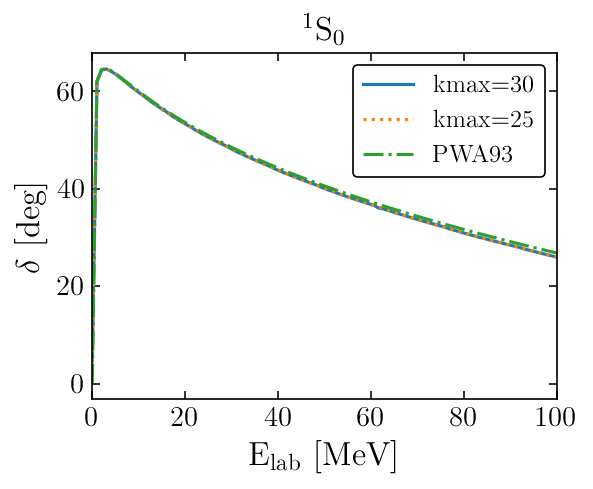

In [16]:
# 1S0 phase shifts with T-matrix
L, Lp, S, J = 0, 0, 0, 0
compare_phase_shifts(L, Lp, S, J)

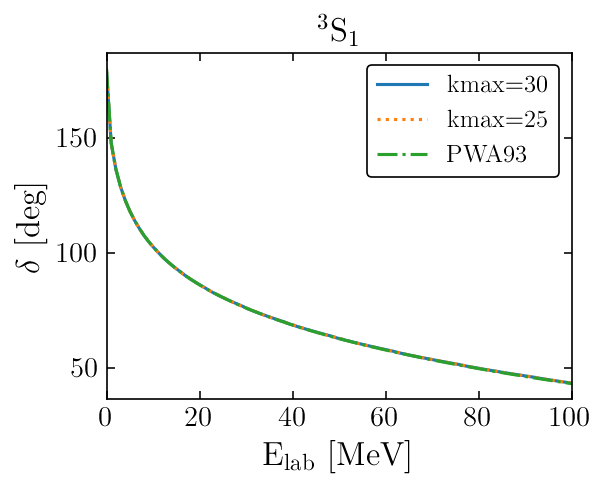

In [17]:
# 3S1 phase shifts with T-matrix
L, Lp, S, J = 0, 0, 1, 1
compare_phase_shifts(L, Lp, S, J)

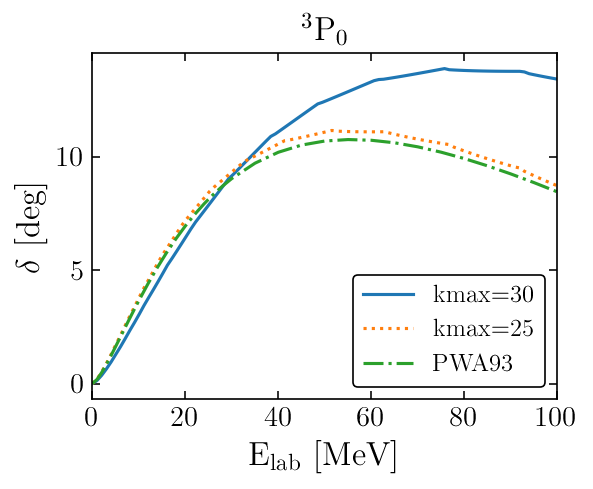

In [18]:
# 3P0 phase shifts with T-matrix
L, Lp, S, J = 1, 1, 1, 0
compare_phase_shifts(L, Lp, S, J)

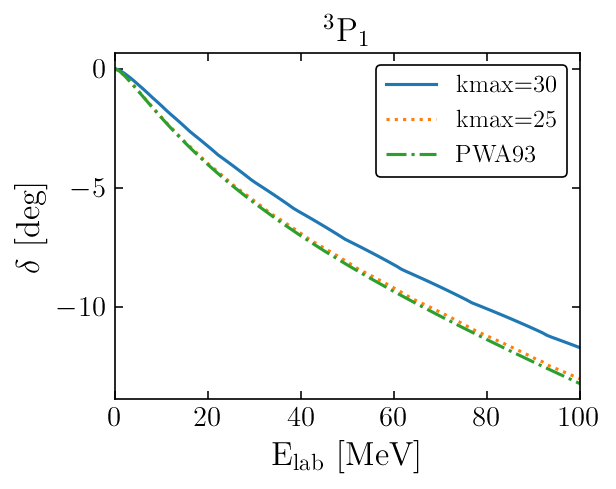

In [19]:
# 3P1 phase shifts with T-matrix
L, Lp, S, J = 1, 1, 1, 1
compare_phase_shifts(L, Lp, S, J)

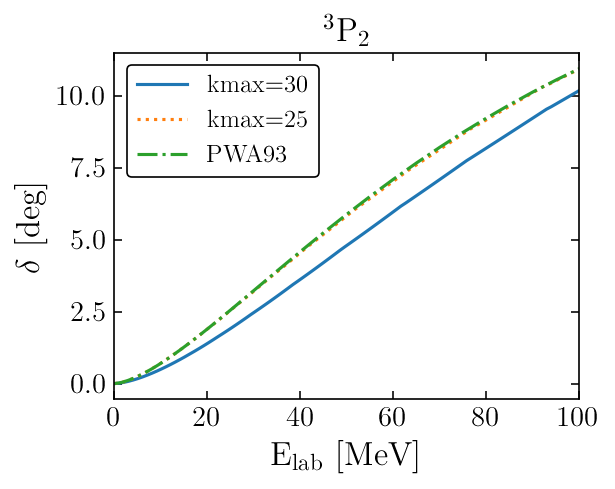

In [20]:
# 3P2 phase shifts with T-matrix
L, Lp, S, J = 1, 1, 1, 2
compare_phase_shifts(L, Lp, S, J)

## $S-$matrix $S_l = 1 - 2 i k T_l$

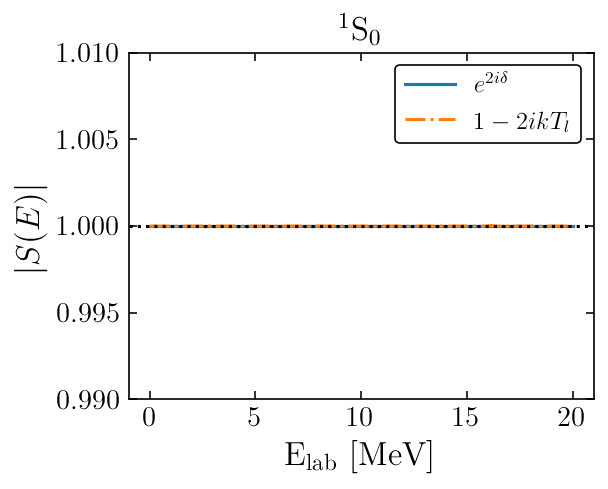

In [21]:
ylim = (0.99, 1.01)
# ylim = None
L, Lp, S, J = 0, 0, 0, 0
check_S_matrix(L, Lp, S, J, y_limits=ylim)

## $\text{Im}[T(k_0, k_0; E_0)] = -k_0 \lvert T(k_0, k_0; E_0) \rvert^2$

In [22]:
L, Lp, S, J = 0, 0, 0, 0
check_unitarity(L, Lp, S, J)

E [MeV] 	 Im[T(E)] [fm] 	 k |T(E)|^2 [fm]

   0.00          -1.941e+00               -1.941e+00        
   0.20          -1.096e+01               -1.096e+01        
   0.41          -9.632e+00               -9.632e+00        
   0.61          -8.534e+00               -8.534e+00        
   0.81          -7.712e+00               -7.712e+00        
   1.01          -7.067e+00               -7.067e+00        
   1.21          -6.555e+00               -6.555e+00        
   1.42          -6.134e+00               -6.134e+00        
   1.62          -5.781e+00               -5.781e+00        
   1.82          -5.478e+00               -5.478e+00        
   2.02          -5.207e+00               -5.207e+00        
   2.22          -4.975e+00               -4.975e+00        
   2.43          -4.769e+00               -4.769e+00        
   2.63          -4.585e+00               -4.585e+00        
   2.83          -4.419e+00               -4.419e+00        
   3.03          -4.267e+00               

## $T_{L,L'}(k, k'; E_0) = T_{L',L}(k', k; E_0)$

In [23]:
k0 = 0.5
check_symmetry(k0)

[[-3.6379788e-12+7.5317530e-13j -2.9103830e-11-4.6611603e-11j
  -5.8207661e-10+2.9194780e-10j ...  6.0708771e-10+2.3283064e-10j
  -2.9103830e-11+1.6007107e-10j -1.4901161e-07+6.3329935e-08j]
 [-9.0949470e-13+5.6843419e-13j  5.8207661e-11-5.1386451e-11j
  -4.6566129e-10+1.9826984e-10j ...  2.9803005e-10+1.8917490e-10j
  -7.3578121e-10+8.7311491e-11j  0.0000000e+00+1.1175871e-07j]
 [ 0.0000000e+00+1.2718715e-12j  4.3655746e-11-4.6156856e-11j
   0.0000000e+00+2.6739144e-10j ... -3.7516656e-12+2.3283064e-10j
  -8.8220986e-11+1.7462298e-10j -1.3411045e-07+8.5681677e-08j]
 ...
 [-1.3877788e-17+6.5052130e-19j -4.4408921e-16-6.9388939e-17j
  -3.5527137e-15+3.6082248e-16j ... -4.6566129e-10+1.9428903e-16j
  -1.3969839e-09+8.3266727e-17j  0.0000000e+00+9.9475983e-14j]
 [ 0.0000000e+00-8.6736174e-19j -2.2204460e-16-7.4593109e-17j
  -1.7763568e-15+1.6653345e-16j ...  0.0000000e+00+2.3592239e-16j
  -1.3969839e-09+2.0816682e-16j  5.6843419e-13+1.7763568e-13j]
 [-1.6555646e-12-5.9685590e-13j -3.13775

In [24]:
k0 = 1.5
check_symmetry(k0)

[[ 1.8189894e-12+4.5474735e-13j  0.0000000e+00+9.0949470e-12j
  -2.3283064e-10-2.9103830e-11j ...  1.5006663e-10-2.2919266e-10j
  -4.5201887e-10-8.9130481e-10j -8.3446503e-07+2.8312206e-07j]
 [-9.0949470e-13+5.6843419e-13j  8.7311491e-11+2.0008883e-11j
  -2.3283064e-10+2.9103830e-11j ... -6.7575456e-10-1.1277734e-10j
  -1.2664714e-09-7.6761353e-10j -7.1525574e-07+3.4272671e-07j]
 [ 9.0949470e-13+4.5474735e-13j  2.9103830e-11+1.4551915e-11j
   0.0000000e+00-8.7311491e-11j ...  3.4197001e-10-2.1100277e-10j
  -1.1241355e-09-9.7134034e-10j -5.3644180e-07+1.6391277e-07j]
 ...
 [ 0.0000000e+00+4.3368087e-19j  0.0000000e+00-6.9388939e-18j
   0.0000000e+00+8.3266727e-17j ... -9.3132257e-10-1.0269563e-15j
  -9.3132257e-10-2.7755576e-15j  0.0000000e+00-1.0231815e-12j]
 [-2.0816682e-17+2.1684043e-19j -2.2204460e-16-3.1225023e-17j
   3.5527137e-15+1.3877788e-16j ... -1.3969839e-09-8.8817842e-16j
  -1.3969839e-09-2.6090241e-15j  2.0463631e-12-1.1368684e-12j]
 [ 3.2684966e-13+1.7053026e-13j  9.09494

## Check that $\text{Im}[1/T(k_0, k_0; E_0)] \propto k$

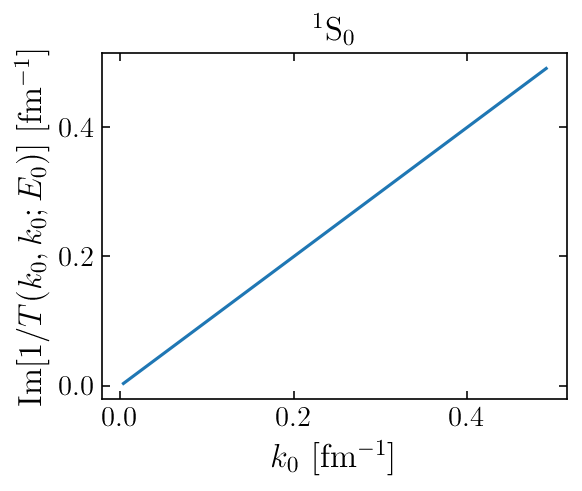

In [25]:
L, Lp, S, J = 0, 0, 0, 0
check_imaginary(L, Lp, S, J)